<div style="background: linear-gradient(to right, #4F46E5, #7C3AED); padding: 30px; border-radius: 15px; margin-bottom: 30px;">
    <h1 style="color: white; font-size: 2.5em; margin-bottom: 15px;">Customer Churn Prediction with Deep Learning</h1>
    <p style="color: rgba(255, 255, 255, 0.9); font-size: 1.1em; line-height: 1.6;">
        Using neural networks to predict customer behavior in the telecom industry
    </p>
    <div style="margin-top: 20px;">
        <span style="background: rgba(255, 255, 255, 0.2); color: white; padding: 8px 16px; border-radius: 20px; margin-right: 10px;">Telecom</span>
        <span style="background: rgba(255, 255, 255, 0.2); color: white; padding: 8px 16px; border-radius: 20px; margin-right: 10px;">Data Science</span>
        <span style="background: rgba(255, 255, 255, 0.2); color: white; padding: 8px 16px; border-radius: 20px;">ML</span>
    </div>
</div>

<div style="background: white; padding: 25px; border-radius: 10px; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1); margin-bottom: 30px;">
    <h2 style="color: #4F46E5; margin-bottom: 20px;">Project Overview</h2>
    <p style="color: #374151; font-size: 1.1em; line-height: 1.6;">
        As Data Scientists at a Digital Services Company specializing in helping telecom operators reduce subscriber loss, 
        you've been assigned to a new client. <span style="color: #4F46E5; font-weight: 500;">TelcoNova</span> wants to anticipate 
        customer departures (<span style="color: #4F46E5; font-weight: 500;">churn</span>) to optimize their retention campaigns.
    </p>
</div>

In [6]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam

from imblearn.over_sampling import SMOTE
import optuna

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure TensorFlow logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [7]:
# Load and preprocess data
df = pd.read_csv('Dataset.csv')

# Data cleaning
df.columns = df.columns.str.strip()
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)

# Feature engineering
X = df.drop(columns=["Churn", "customerID"])
y = df["Churn"].map({"No": 0, "Yes": 1})

# Convert TotalCharges to numeric
X["TotalCharges"] = pd.to_numeric(X["TotalCharges"], errors="coerce")
X.dropna(subset=["TotalCharges"], inplace=True)

# Define feature types
numeric_cols = ["SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges"]
categorical_cols = [c for c in X.columns if c not in numeric_cols]

# Create preprocessor with target encoding for categoricals
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("cat", TargetEncoder(cols=categorical_cols), categorical_cols),
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

/tmp/ipykernel_113179/3466438929.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [8]:
# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to optimize
    n_layers = trial.suggest_int('n_layers', 1, 3)
    n_units = [trial.suggest_int(f'n_units_l{i}', 16, 256) for i in range(n_layers)]
    dropout_rates = [trial.suggest_float(f'dropout_l{i}', 0.1, 0.5) for i in range(n_layers)]
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    
    # Preprocess data
    X_train_processed = preprocessor.fit_transform(X_train,y_train)
    X_test_processed = preprocessor.transform(X_test)
    
    # Apply SMOTE for class balancing
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)
    
    # Build model
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(X_train_processed.shape[1],)))
    
    for i in range(n_layers):
        model.add(layers.Dense(n_units[i], activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout_rates[i]))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    # Train with early stopping
    early_stopping = callbacks.EarlyStopping(
        monitor='val_auc',
        patience=5,
        restore_best_weights=True,
        mode='max'
    )
    
    history = model.fit(
        X_train_balanced, y_train_balanced,
        validation_split=0.2,
        epochs=50,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=0
    )
    
    return max(history.history['val_auc'])

# Run hyperparameter optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-05-22 11:07:03,539] A new study created in memory with name: no-name-32530a17-400e-46c5-8be9-ca93665d68ad
[I 2025-05-22 11:07:15,138] Trial 0 finished with value: 0.0 and parameters: {'n_layers': 1, 'n_units_l0': 234, 'dropout_l0': 0.27825788273365515, 'learning_rate': 0.0032996077362056286, 'batch_size': 16}. Best is trial 0 with value: 0.0.
[I 2025-05-22 11:07:21,202] Trial 1 finished with value: 0.0 and parameters: {'n_layers': 2, 'n_units_l0': 166, 'n_units_l1': 126, 'dropout_l0': 0.10634086048642005, 'dropout_l1': 0.2321040569474238, 'learning_rate': 0.0001435424239941482, 'batch_size': 32}. Best is trial 0 with value: 0.0.
[I 2025-05-22 11:07:25,734] Trial 2 finished with value: 0.0 and parameters: {'n_layers': 3, 'n_units_l0': 68, 'n_units_l1': 177, 'n_units_l2': 209, 'dropout_l0': 0.3867538463112663, 'dropout_l1': 0.42949507425505395, 'dropout_l2': 0.3380960721170479, 'learning_rate': 0.001945600553647398, 'batch_size': 128}. Best is trial 0 with value: 0.0.
[I 2025-05-

Best trial:
  Value: 0.0
  Params: 
    n_layers: 1
    n_units_l0: 234
    dropout_l0: 0.27825788273365515
    learning_rate: 0.0032996077362056286
    batch_size: 16


In [9]:
# Train final model with best hyperparameters
def create_final_model(trial):
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(X_train_processed.shape[1],)))
    
    for i in range(trial.params['n_layers']):
        model.add(layers.Dense(trial.params[f'n_units_l{i}'], activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(trial.params[f'dropout_l{i}']))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=Adam(learning_rate=trial.params['learning_rate']),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

# Preprocess final training data
X_train_processed = preprocessor.fit_transform(X_train, y_train)
X_test_processed = preprocessor.transform(X_test)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)

# Create and train final model
final_model = create_final_model(study.best_trial)

# Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_auc',
    patience=5,
    restore_best_weights=True,
    mode='max'
)

model_checkpoint = callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='val_auc',
    save_best_only=True,
    mode='max'
)

# Train final model
history = final_model.fit(
    X_train_balanced, y_train_balanced,
    validation_split=0.2,
    epochs=50,
    batch_size=study.best_trial.params['batch_size'],
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/50
392/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7254 - auc: 0.7867 - loss: 0.5525

413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7264 - auc: 0.7878 - loss: 0.5510 - val_accuracy: 0.8081 - val_auc: 0.0000e+00 - val_loss: 0.4518
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7621 - auc: 0.8255 - loss: 0.4898 - val_accuracy: 0.8002 - val_auc: 0.0000e+00 - val_loss: 0.4758
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7610 - auc: 0.8282 - loss: 0.4854 - val_accuracy: 0.8075 - val_auc: 0.0000e+00 - val_loss: 0.4597
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7644 - auc: 0.8323 - loss: 0.4791 - val_accuracy: 0.7960 - val_auc: 0.0000e+00 - val_loss: 0.4654
Epoch 5/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7617 - auc: 0.8339 - loss: 0.4786 - val_accuracy: 0.7990 - val_auc: 0.0000e+00 - val_loss: 0.4604
Epoch 6/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7666 - auc: 0.8328 - loss: 0.4795 - val_accuracy: 0.7736 - val_auc: 0.0000e+00 - val_loss: 0.5298


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1033
           1       0.50      0.78      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.75      1407



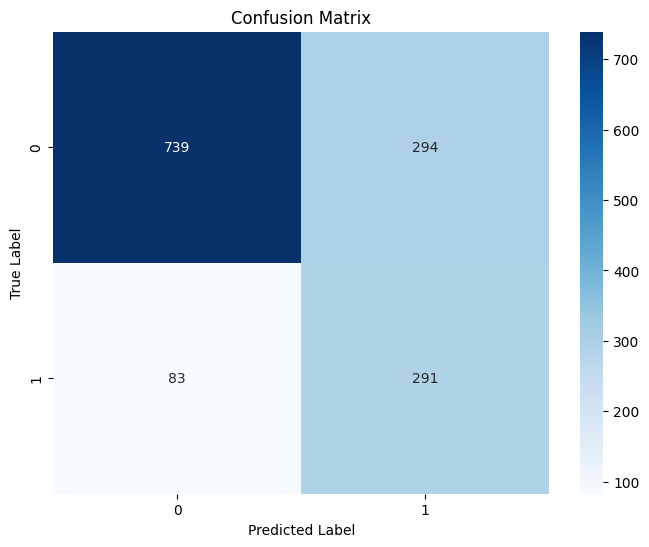

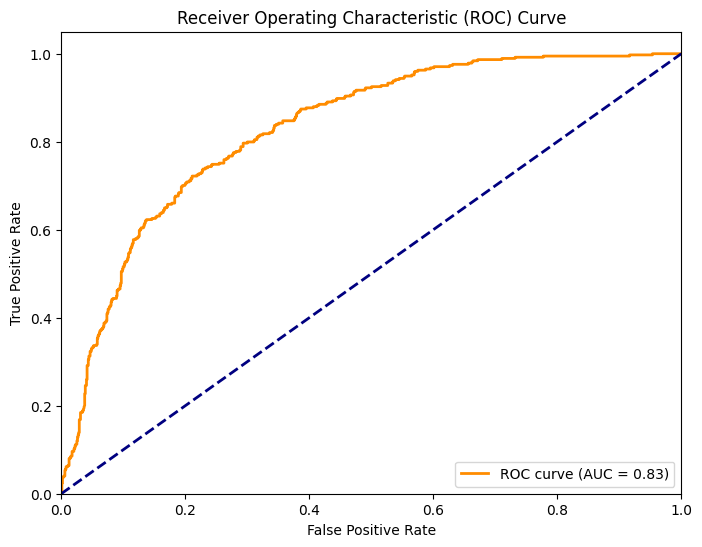

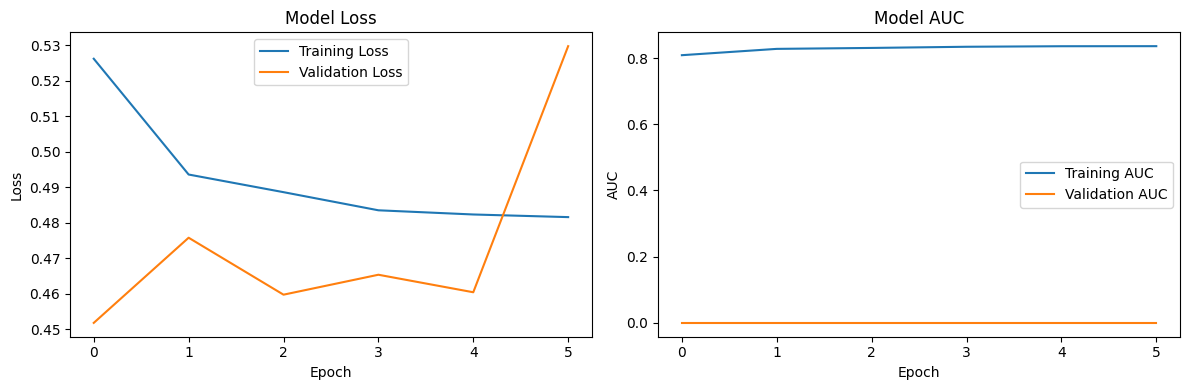

In [10]:
# Evaluate final model
y_pred_prob = final_model.predict(X_test_processed)
y_pred = (y_pred_prob > 0.5).astype(int)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()